# Modélisation Regression Paris 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
#from sklearn import model_selection, preprocessing
#from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator,TransformerMixin
pd.set_option('display.max_columns', None)
from sklearn.linear_model import Lasso, lasso_path, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import skew

Chargement base DVF, base concernant les salaires, et concernant la population

In [3]:
df = pd.read_csv("06 - dvf_with_equip_loyers_revenus_2020v2.csv")

#On garde la france metropolitaine
df = df[df["Code departement"] == 75]

#on intègre les salaires
salaire = pd.read_csv("salaire.csv",sep=";",decimal=",",dtype = {'Code departement': int})
salaire = salaire[['SNHMO18','SNHMFO18',"Code departement"]]
df = df.merge(salaire, on = "Code departement", how = 'left')
del salaire

#on intègre la population par commune
population = pd.read_csv("population.csv", sep =";", dtype = {'Population municipale': int,
                                                              'Population comptee a part':int,
                                                              'Population totale':int,
                                                              'Code commune INSEE':int})
population = population[["Population totale",'Code commune INSEE']]
df = df.merge(population, on = "Code commune INSEE", how = 'left')
del population


df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']] = df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']].fillna(df[['DISP_Q118','DISP_MED18','DISP_Q318','DISP_GI18']].mean())
df = df.fillna(0)

Création des nouvelles features 

In [4]:
#Prix moyen par département
prix_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par departement'},axis =1)
df = df.merge(prix_moyen_dept, on = "dep_name", how = "left")
del prix_moyen_dept

#Prix moyen m2 par département
prix_m2_moyen_dept = pd.DataFrame(df.groupby(["dep_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par departement'},axis =1)
df = df.merge(prix_m2_moyen_dept, on = "dep_name", how = "left")
del prix_m2_moyen_dept

#prix moyen par région
prix_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par region'},axis =1)
df = df.merge(prix_moyen_reg, on = "region_name", how = "left")
del prix_moyen_reg

#prix moyen m2 par région
prix_m2_moyen_reg = pd.DataFrame(df.groupby(["region_name"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par region'},axis =1)
df = df.merge(prix_m2_moyen_reg, on = "region_name", how = "left")
del prix_m2_moyen_reg

#prix moyen par commune
prix_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Valeur fonciere"]).rename({"Valeur fonciere":'Prix moyen par commune'},axis =1)
df = df.merge(prix_moyen_commune, on = "Commune", how = "left")
del prix_moyen_commune

#prix moyen par commune
prix_m2_moyen_commune = pd.DataFrame(df.groupby(["Commune"]).mean()["Prix m2"]).rename({"Prix m2":'Prix m2 moyen par commune'},axis =1)
df = df.merge(prix_m2_moyen_commune, on = "Commune", how = "left")
del prix_m2_moyen_commune

#loyer moyen
df["loyer_moyen"] = (df["loy_maison"]+ df["loy_appart"])/2


df["Nb equip total"] = df["Alimentation"] + df["Aéroport"] +df["Baignade"] +df["Banques"] +df["Boulangerie"] +df["Camping"] 
df["Nb equip total"] = df["Nb equip total"] + df["Cinéma"] +df["Collège ou lycée"] +df["Crèche"] +df["Ecole mat et primaire"] 
df["Nb equip total"] = df["Nb equip total"]+df["Ecole sup"] +df["Etab hospi"] +df["Gare"] +df["Gare nationale"] +df["Hotels"] 
df["Nb equip total"] = df["Nb equip total"]+df["Info touristique"] +df["Parcours sportif/santé"]  +df["Pharmacie"]   
df["Nb equip total"] = df["Nb equip total"]+df["Police ou gendarmerie"]+df["Port plaisance"]+df["Restaurants"]+df["Resto U"] 
df["Nb equip total"] = df["Nb equip total"]+df["Résidence U"] +  df["Salle multisport"]

df.drop(['Unnamed: 0', 'Date mutation','Type de voie','Nombre de lots',
         'Code commune INSEE', 'Adresse','lon', 'lat', 'Code postal 5 chiffres',
         'code_iris_clean','Code departement','dep_name','region_name','Commune',
         'année','mois','keepdep','Prix m2'], axis = 1, inplace = True)


#del cor
objet = df[["Type local"]]
df.drop(["Type local"], axis = 1, inplace = True)
df = df.join(pd.get_dummies(objet))
del objet

In [5]:
df.shape

(17856, 49)

In [6]:
threshold = 1e-3
sel = VarianceThreshold(threshold)
sel.fit(df)
#df_feat_sel = sel.transform(df, df.columns)

VarianceThreshold(threshold=0.001)

In [7]:
mask = sel.get_support()
tempo = pd.DataFrame(df.columns,mask, columns = ["Col"]).reset_index()
tempo = tempo[tempo["index"]==True]
df = pd.DataFrame(sel.transform(df), columns = list(tempo['Col']))
del tempo

In [8]:
df.shape

(17856, 35)

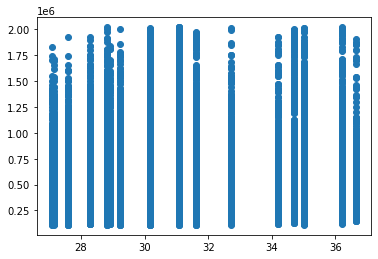

In [9]:
plt.scatter(df["loy_appart"],df["Valeur fonciere"])

In [23]:
df["loy_appart"].value_counts()

28.829441    2446
27.585489    2078
30.177892    1959
29.223528    1936
31.080411    1747
27.140621    1136
28.287894    1135
27.080872    1004
28.912789     932
31.617569     785
32.707463     586
34.698076     527
34.206456     518
36.200039     454
35.002977     398
36.654438     215
Name: loy_appart, dtype: int64

On repère quelques corrélations entre certaines variables (celles vers la fin, prix moyen et prix moyen par m2)

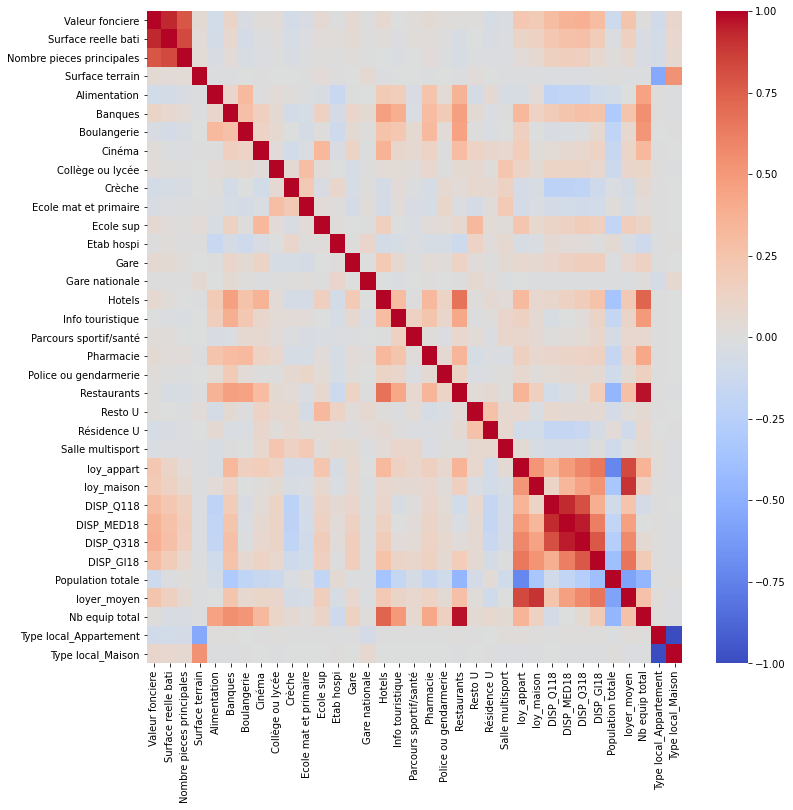

In [84]:
cor = df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, ax= ax, cmap="coolwarm");

Varaibles les plus corrélées avec notre target.

In [85]:
cor['Valeur fonciere'].sort_values(ascending = False)

Valeur fonciere              1.000000
Surface reelle bati          0.935382
Nombre pieces principales    0.784829
DISP_Q318                    0.378766
DISP_MED18                   0.359884
DISP_Q118                    0.301527
DISP_GI18                    0.298703
loyer_moyen                  0.246562
loy_appart                   0.233047
loy_maison                   0.201314
Banques                      0.114365
Type local_Maison            0.091734
Hotels                       0.069346
Gare                         0.060468
Ecole sup                    0.056590
Pharmacie                    0.052952
Surface terrain              0.047951
Collège ou lycée             0.025204
Cinéma                       0.022732
Police ou gendarmerie        0.020194
Parcours sportif/santé       0.019437
Resto U                      0.015233
Nb equip total               0.012617
Restaurants                  0.008927
Etab hospi                   0.007067
Gare nationale               0.003284
Info tourist

Les équipements ne ressortent pas réellement, une piste serait des les utiliser différement

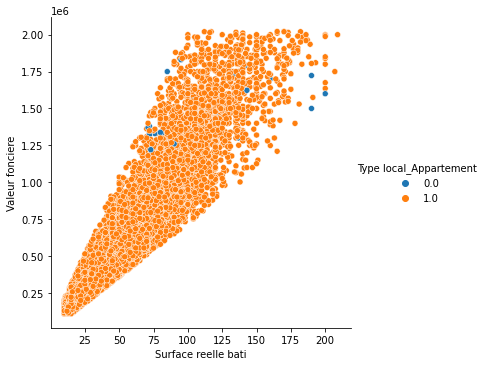

In [86]:
sns.relplot(x="Surface reelle bati",y="Valeur fonciere",hue="Type local_Appartement", data = df);

In [87]:
df["Type local_Appartement"].value_counts()

1.0    17818
0.0       38
Name: Type local_Appartement, dtype: int64

In [149]:
target = df["Valeur fonciere"]
data = df.drop("Valeur fonciere",axis = 1)


In [114]:
#target = np.log(df["Valeur fonciere"])

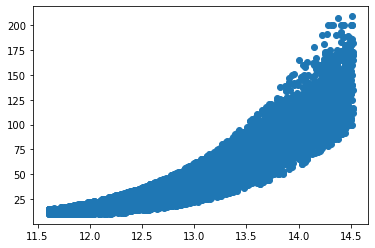

In [115]:
#plt.scatter(target,data["Surface reelle bati"]);

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)

In [92]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### Regression linéaire standard

In [93]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Coefficient de détermination du modèle :", lr.score(X_train, y_train))
print('Score de l ensemble de test', lr.score(X_test,y_test))
print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE test : ", mean_absolute_error(y_test, y_pred))
res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
res

Coefficient de détermination du modèle : 0.8985645501605383
Score de l ensemble de test 0.8961985095544559
RMSE test :  121350.63172930737
MAE test :  80765.50571659618


,Actual,Predicted
4299,122000.0,9.902821e+04
4410,409000.0,3.825660e+05
12921,1174000.0,1.355396e+06
10671,475000.0,4.666330e+05
3944,1030000.0,1.132080e+06
...,...,...
17405,237900.0,2.248671e+05
8904,710000.0,6.805276e+05
5209,625000.0,5.069843e+05
2422,250000.0,3.688870e+05


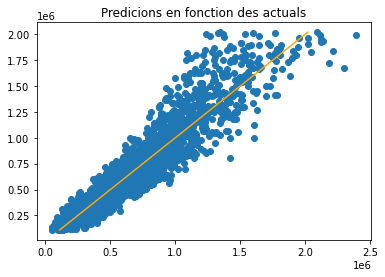

In [94]:
plt.scatter(y_pred, y_test)
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max()), 'orange')
plt.title("Predicions en fonction des actuals");

Gros doute sur la linéarité de la relation

Analyse des résidus : à controler l'homoscédasticité et la normalité

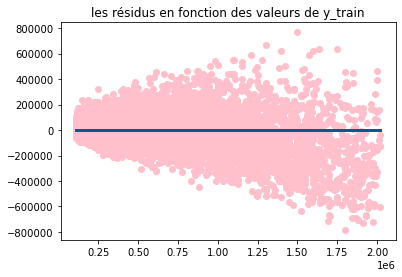

In [95]:
pred_train = lr.predict(X_train)
residus = pred_train - y_train
plt.scatter(y_train, residus, color = 'pink')
plt.plot((y_train.min(),y_train.max()), (0,0), lw=3, color = '#0a5798')
plt.title("les résidus en fonction des valeurs de y_train");

Clairement on a pas de répartition uniforme autour de la droite d'axe y= 0.

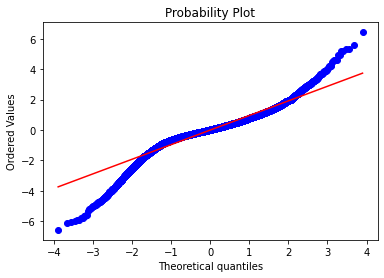

In [96]:
residus_norm = (residus-residus.mean())/residus.std()
stats.probplot(residus_norm, plot = plt)
plt.show()

Clairement les résidus n'ont pas un comportement gaussien !!!

In [98]:
cor['Valeur fonciere'].sort_values(ascending = False)[:10]

Valeur fonciere              1.000000
Surface reelle bati          0.935382
Nombre pieces principales    0.784829
DISP_Q318                    0.378766
DISP_MED18                   0.359884
DISP_Q118                    0.301527
DISP_GI18                    0.298703
loyer_moyen                  0.246562
loy_appart                   0.233047
loy_maison                   0.201314
Name: Valeur fonciere, dtype: float64

In [101]:
signif_feat= df[["Valeur fonciere","Surface reelle bati","Nombre pieces principales","DISP_Q318",
                 "DISP_MED18","DISP_Q118","DISP_GI18","loyer_moyen","loy_appart","loy_maison"]]

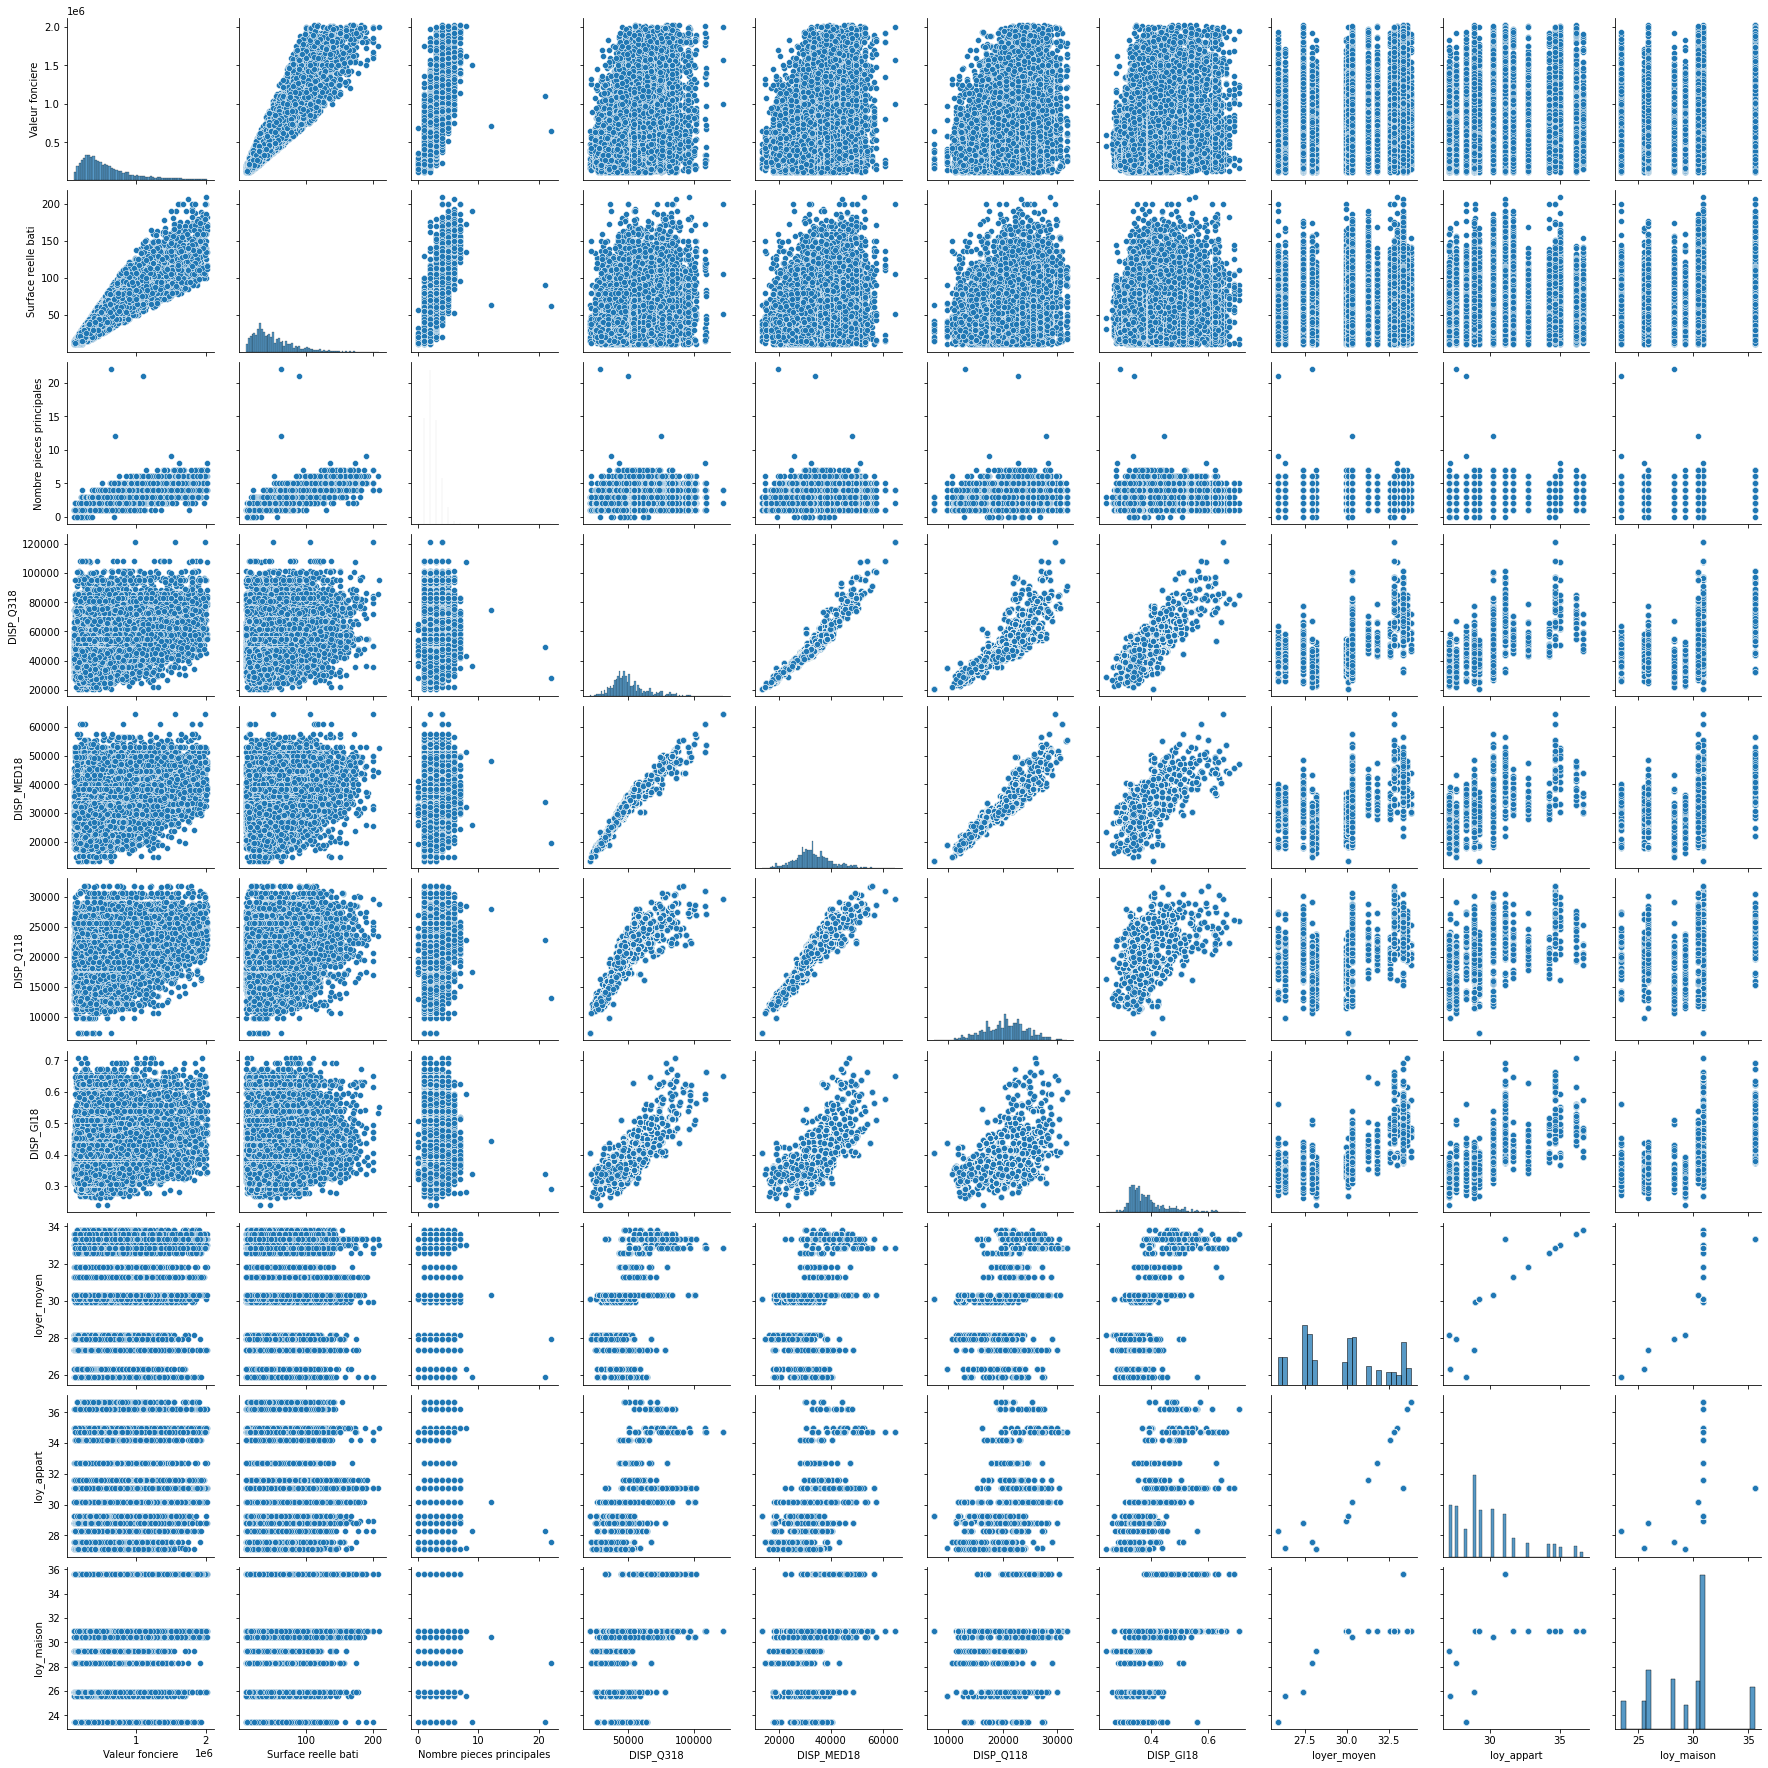

In [102]:
sns.pairplot(signif_feat)

# Regression Lasso

In [116]:
lasso_r=Lasso(alpha=0.8,max_iter=10000)
lasso_r.fit(X_train,y_train)
lasso_r.coef_
lasso_r_pred = lasso_r.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29985353809266.406, tolerance: 199819222209.12692
  model = cd_fast.enet_coordinate_descent(


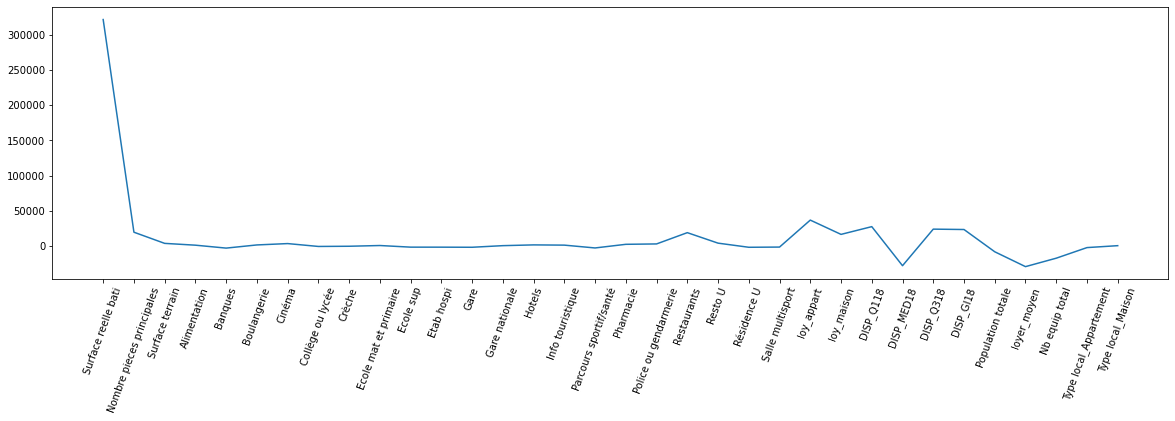

In [112]:
plt.subplots(figsize=(20,5))
coef = pd.DataFrame(model_lasso.coef_)
plt.plot(range(len(data.columns)), coef[0])
plt.xticks(range(len(data.columns)),data.columns.values, rotation= 70)
plt.show;

In [113]:
print("score test:", lasso_r.score(X_test, y_test))
print("rmse test:", np.sqrt(mean_squared_error(lasso_r_pred, y_test)))
print("rmse test:", mean_absolute_error(lasso_r_pred, y_test))

score test: 0.8961980663905837
rmse test: 121350.89077259382
rmse test: 80765.14201021318


Essaie de selection de modèles

In [245]:
from sklearn.feature_selection import SelectKBest, f_regression
sk = SelectKBest(f_regression, k=11)
sk.fit(data, target)
print(data.columns[sk.get_support()])
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)
sklr = LinearRegression()
sklr.fit(sk_train, y_train)
y_pred_sklr = sklr.predict(sk_test)
print(sklr.score(sk_train, y_train))
print(sklr.score(sk_test, y_test))
print("RMSE test : ", np.sqrt(mean_squared_error(y_test, y_pred_sklr)))
print("MAE test : ", mean_absolute_error(y_test, y_pred_sklr))

Index(['Surface reelle bati', 'Nombre pieces principales', 'loy_appart',
       'loy_maison', 'Prix moyen par departement',
       'Prix m2 moyen par departement', 'Prix moyen par region',
       'Prix m2 moyen par region', 'Prix moyen par commune',
       'Prix m2 moyen par commune', 'loyer_moyen'],
      dtype='object')
0.7071143209694775
0.7089271834326221
RMSE test :  81036.55334636635
MAE test :  53665.951755689755


In [20]:
res_sklr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_sklr})
res_sklr

,Actual,Predicted
250976,126000.0,163260.824968
468943,67416.0,90081.048929
354563,142000.0,166758.639199
49003,121900.0,130395.334318
309520,51300.0,11029.332600
...,...,...
304381,133300.0,148826.500316
408570,280000.0,293222.752530
159071,55000.0,66956.518304
59772,132620.0,208535.043266


### Random Forest

In [117]:
regr = RandomForestRegressor(random_state=0,n_jobs=-1)
regr.fit(X_train,y_train)
print("score train:",regr.score(X_train, y_train))
print("score test:", regr.score(X_test, y_test))
pred_rf = regr.predict(X_test)
print("RMSE test : ", np.sqrt(mean_squared_error(pred_rf,y_test)))
print("MAE test : ", mean_absolute_error(y_test, pred_rf))
res_rf = pd.DataFrame({'Actual': y_test, 'Predicted': pred_rf})
res_rf

score train: 0.9840064453484388
score test: 0.9035753758329124
RMSE test :  116959.1556087096
MAE test :  77994.17691355466


,Actual,Predicted
4299,122000.0,1.559390e+05
4410,409000.0,4.239682e+05
12921,1174000.0,1.287464e+06
10671,475000.0,4.448139e+05
3944,1030000.0,1.223589e+06
...,...,...
17405,237900.0,2.456912e+05
8904,710000.0,6.196783e+05
5209,625000.0,5.037916e+05
2422,250000.0,2.695713e+05


### Support Vector Regressor

In [118]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR()

In [127]:
print("score train:",regressor.score(X_train, y_train))
print("score test:", regressor.score(X_test, y_test))
pred_svr = regressor.predict(X_test)
print(" RMSE test : ", np.sqrt(mean_squared_error(pred_svr,y_test)))
print("MAE test : ", mean_absolute_error(y_test, pred_svr))
res_svr = pd.DataFrame({'Actual': y_test, 'Predicted': pred_svr})
res_svr

score train: -0.08187865164237462
score test: -0.08094485086665237
 E test :  391599.3978782443
MAE test :  272977.3933837658


,Actual,Predicted
4299,122000.0,475070.406502
4410,409000.0,474930.615193
12921,1174000.0,476250.522272
10671,475000.0,474900.347156
3944,1030000.0,475517.608281
...,...,...
17405,237900.0,474649.961184
8904,710000.0,475215.120216
5209,625000.0,475181.600789
2422,250000.0,475521.275934


# KNN

In [122]:
knn = KNeighborsRegressor()
param_grid = {"n_neighbors": np.arange(1,25,1)}
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)
print("Le meilleur paramètre est : " ,knn_gscv.best_params_)
print("Le score est : ",knn_gscv.best_score_)

Le meilleur paramètre est :  {'n_neighbors': 2}
Le score est :  0.7918511843252822


In [128]:
print("score train KNN:",knn_gscv.score(X_train, y_train))
print("score test KNN:", knn_gscv.score(X_test, y_test))
pred_knn = knn_gscv.predict(X_test)
print(" RMSE test : ", np.sqrt(mean_squared_error(pred_knn,y_test)))
print("MAE test : ", mean_absolute_error(y_test, pred_knn))
res_svr = pd.DataFrame({'Actual': y_test, 'Predicted': pred_knn})
res_svr



score train KNN: 0.9454226408454236
score test KNN: 0.8194219966500025
 RMSE test :  160056.2620526275
MAE test :  105306.26705207166


,Actual,Predicted
4299,122000.0,180250.0
4410,409000.0,434250.0
12921,1174000.0,1517500.0
10671,475000.0,412000.0
3944,1030000.0,999000.0
...,...,...
17405,237900.0,259000.0
8904,710000.0,655000.0
5209,625000.0,551463.0
2422,250000.0,765000.0
